In [145]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

In [146]:
keras.backend.set_image_dim_ordering('th')

In [147]:
model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

In [148]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_145 (Conv2D)          (None, 16, 448, 448)      448       
_________________________________________________________________
leaky_re_lu_161 (LeakyReLU)  (None, 16, 448, 448)      0         
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 16, 224, 224)      0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 32, 224, 224)      4640      
_________________________________________________________________
leaky_re_lu_162 (LeakyReLU)  (None, 32, 224, 224)      0         
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 32, 112, 112)      0         
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 64, 112, 112)      18496     
__________

In [149]:
def load_weights(model,yolo_weight_file):
                
    data = np.fromfile(yolo_weight_file,np.float32)
    data=data[4:]
    
    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            bia = data[index:index+np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index+np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker,bia])
            
# https://pjreddie.com/darknet/yolo/
load_weights(model,'./yolov1.weights')

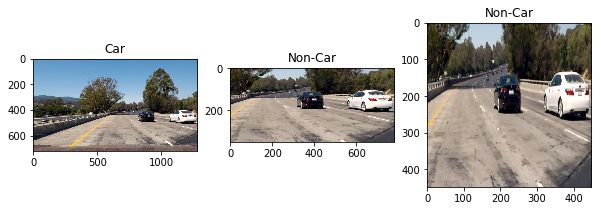

In [150]:
imagePath = './test_images/test1.jpg'
image = plt.imread(imagePath)

image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))

plt.figure(figsize=(10,40))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title('Car')

plt.subplot(1,3,2)
plt.imshow(image_crop)
plt.title('Non-Car')

plt.subplot(1,3,3)
plt.imshow(resized)
plt.title('Non-Car')

In [151]:
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
out = model.predict(batch)

In [152]:
class box:
    def __init__(self,classes):
        self.x = 0
        self.y = 0
        self.h = 0
        self.w = 0
        self.class_num = 0
        self.probs = np.zeros((classes,1))

def convert_yolo_detections(predictions,classes=20,num=2,square=True,side=7,w=1,h=1,threshold=0.2,only_objectness=0):
    boxes = []
    probs = np.zeros((side*side*num,classes))
    for i in range(side*side):
        row = i / side
        col = i % side
        for n in range(num):
            index = i*num+n
            p_index = side*side*classes+i*num+n
            scale = predictions[p_index]
            box_index = side*side*(classes+num) + (i*num+n)*4

            new_box = box(classes)
            new_box.x = (predictions[box_index + 0] + col) / side * w
            new_box.y = (predictions[box_index + 1] + row) / side * h
            new_box.h = pow(predictions[box_index + 2], 2) * w
            new_box.w = pow(predictions[box_index + 3], 2) * h

            for j in range(classes):
                class_index = i*classes
                prob = scale*predictions[class_index+j]
                if(prob > threshold):
                    new_box.probs[j] = prob
                else:
                    new_box.probs[j] = 0
                    
            if(only_objectness):
                new_box.probs[0] = scale

            boxes.append(new_box)
            
    return boxes

def prob_compare(boxa,boxb):
    if(boxa.probs[boxa.class_num] < boxb.probs[boxb.class_num]):
        return 1
    elif(boxa.probs[boxa.class_num] == boxb.probs[boxb.class_num]):
        return 0
    else:
        return -1
   
    
def cmp_to_key(mycmp):
    'Convert a cmp= function into a key= function'
    class K(object):
        def __init__(self, obj, *args):
            self.obj = obj
        def __lt__(self, other):
            return mycmp(self.obj, other.obj) < 0
        def __gt__(self, other):
            return mycmp(self.obj, other.obj) > 0
        def __eq__(self, other):
            return mycmp(self.obj, other.obj) == 0
        def __le__(self, other):
            return mycmp(self.obj, other.obj) <= 0  
        def __ge__(self, other):
            return mycmp(self.obj, other.obj) >= 0
        def __ne__(self, other):
            return mycmp(self.obj, other.obj) != 0
    return K    

def box_iou(a, b):
    return box_intersection(a, b)/box_union(a, b);

def box_intersection(a, b):
    w = overlap(a.x, a.w, b.x, b.w);
    h = overlap(a.y, a.h, b.y, b.h);
    if(w < 0 or h < 0):
         return 0;
    area = w*h;
    return area;

def overlap(x1,w1,x2,w2):
    l1 = x1 - w1/2;
    l2 = x2 - w2/2;
    if(l1 > l2):
        left = l1
    else:
        left = l2
    r1 = x1 + w1/2;
    r2 = x2 + w2/2;
    if(r1 < r2):
        right = r1
    else:
        right = r2
    return right - left;

def box_union(a, b):
    i = box_intersection(a, b);
    u = a.w*a.h + b.w*b.h - i;
    return u;

def do_nms_sort(boxes,total,classes=20,thresh=0.5):
    for k in range(classes):
        for box in boxes:
            box.class_num = k
            
        sorted_boxes = sorted(boxes, key=cmp_to_key(prob_compare) )
        
        for i in range(total):
            if(sorted_boxes[i].probs[k] == 0):
                continue
            boxa = sorted_boxes[i]
            for j in range(i+1,total):
                boxb = sorted_boxes[j]
                if(boxb.probs[k] != 0 and box_iou(boxa,boxb) > thresh):
                    boxb.probs[k] = 0
                    sorted_boxes[j] = boxb
    return sorted_boxes

def draw_detections(impath,num,thresh,boxes,classes,labels,save_name):
    """
    Args:
        impath: The image path
        num: total number of bounding boxes
        thresh: boxes prob beyond this thresh will be drawn
        boxes: boxes predicted by the network
        classes: class numbers of the objects
    """
    img = Image.open(impath)
    drawable = ImageDraw.Draw(img)
    ImageSize = img.size
    for i in range(num):
        #for each box, find the class with maximum prob
        max_class = np.argmax(boxes[i].probs)
        prob = boxes[i].probs[max_class]
        if(prob > thresh):
            b = boxes[i]

            temp = b.w
            b.w = b.h
            b.h = temp

            left  = (b.x-b.w/2.)*ImageSize[0];
            right = (b.x+b.w/2.)*ImageSize[0];
            top   = (b.y-b.h/2.)*ImageSize[1];
            bot   = (b.y+b.h/2.)*ImageSize[1];

            if(left < 0): left = 0;
            if(right > ImageSize[0]-1): right = ImageSize[0]-1;
            if(top < 0): top = 0;
            if(bot > ImageSize[1]-1): bot = ImageSize[1]-1;

            if max_class == 6:
                drawable.rectangle([left,top,right,bot],outline="red")
                print (labels[max_class] + ": " + str(boxes[i].probs[max_class]))
                print ("The four cords are: " + str(left) + ", " + str(right) + ", " + str(top) + ", " + str(bot))

    img.save(os.path.join(os.getcwd(),'results',save_name ))
           

In [153]:
from PIL import Image
from PIL import ImageDraw
import os

labels = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train","tvmonitor"]
predictions = out[0]
boxes = convert_yolo_detections(predictions,  threshold = 0.9)
print(len(boxes))
boxes = do_nms_sort(boxes,98)
draw_detections(imagePath,98,0.2,boxes,20,labels,"test.png")

98
car: [ 28.75303459]
The four cords are: 0, 1279, 108.173107589, 719
car: [ 4.32991838]
The four cords are: 0, 1279, 0, 719
car: [ 7.1898551]
The four cords are: 0, 1279, 0, 719
car: [ 2.87027144]
The four cords are: 0, 503.275235921, 0, 719
